In [1]:
import numpy as np
import os
from matplotlib import image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import cv2 as cv
import numpy.matlib
from sklearn.neighbors import KernelDensity

from nerfnav.feature_map import FeatureMap
from nerfnav.utils import sample_from_ball_2d, pc_plot_trace

%load_ext autoreload
%autoreload 2

Given collection of local cost samples in a cluster, update the global cost values in the cluster.

All (x,y,z) in global coords.

local cost samples: [(x,y,z), cost], ...
NeRF: given (x,y,z), compute feature f(x,y,z)
 - For now, can use f(x,y,z) as RGB value of top down view of scene.

Interpolate over points (x,y,z) in cluster.



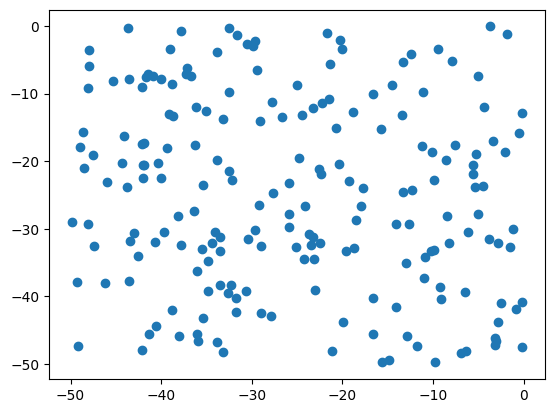

In [2]:
# Simulate local cost samples: points on circle in xy with random z
#xy_pts = sample_from_ball_2d(200, radius=50.0)
xy_pts = np.random.uniform(low=-50.0, high=0.0, size=(200,2))
plt.scatter(x=xy_pts[:,0], y=xy_pts[:,1])
plt.show()

In [3]:
# Random cost values between -1 and 1
#c_pts = np.random.uniform(-10.0, 10.0, xy_pts.shape[0])
c_pts = np.ones(xy_pts.shape[0])

# xyc_pts = np.hstack((xy_pts, c_pts.reshape((-1,1))))
# fig = go.Figure(data = pc_plot_trace(xyc_pts, color=c_pts, size=2))
# fig.update_layout(width=1200, height=600, scene=dict(aspectmode='data'))
# fig.show()

In [4]:
# Fake map image
global_img = np.zeros((101, 101, 3))

# Set colors
global_img[:,30:70,2] = 255
global_img[:,:30,0] = 255
global_img[:,70:,0] = 255

fig = px.imshow(global_img)
fig.update_layout(width=800, height=800)
fig.show()

In [5]:
h, w, _ = global_img.shape

In [8]:
fm = FeatureMap(global_img, (h//2, w//2), (0,0), np.array([0,0,0]), np.array([0,0,0]))

In [ ]:
def get_features(x):
    XMAX = 50.0
    return np.hstack((x, fm.get_features(x)))

In [ ]:
# Sample features
n = len(xyc_pts)
F_samples = get_features(xyc_pts[:,:2])
samples_mat = xyc_pts[:,2][:,None] * F_samples
samples_vec = samples_mat.reshape(-1)

In [ ]:
# Eval points
x_grid = np.linspace(-50, 50, 101)
y_grid = np.linspace(-50, 50, 101)
xx, yy = np.meshgrid(x_grid, y_grid)
X_eval = np.vstack([xx.ravel(), yy.ravel()]).T
F = get_features(X_eval)
F_mat = np.matlib.repmat(F, 1, n)
costs = F_mat @ samples_vec / 5.0

In [ ]:
F_mat.shape

In [ ]:
xyc_grid = np.hstack((X_eval, costs[:,None]))

In [ ]:
fig = go.Figure(data = pc_plot_trace(xyc_grid, color=costs, size=2))

fig.add_trace(pc_plot_trace(xyc_pts, color=c_pts, size=5))
fig.update_layout(width=1200, height=600, scene=dict(aspectmode='data'))
fig.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a toy RGB image of size 100x100
image_size = 100
toy_image = np.random.randint(0, 256, (image_size, image_size, 3), dtype=np.uint8)

# Extract (x, y, R, G, B) features from the toy image
X, Y = np.meshgrid(np.arange(image_size), np.arange(image_size))
features = np.stack([X.flatten(), Y.flatten(), 
                     toy_image[:, :, 0].flatten(), 
                     toy_image[:, :, 1].flatten(), 
                     toy_image[:, :, 2].flatten()], axis=1)

from sklearn.neighbors import KernelDensity

# Randomly subsample the features for KDE
sample_size = 1000
sample_indices = np.random.choice(features.shape[0], sample_size, replace=False)
sample_features = features[sample_indices]

# List of different kernels
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']

# Calculate KDE for each kernel type
density_values = {}
for kernel in kernels:
    kde = KernelDensity(kernel=kernel, bandwidth=1.0).fit(sample_features)
    density = np.exp(kde.score_samples(features))
    density_values[kernel] = density.reshape(image_size, image_size)

In [ ]:
global_img = np.zeros((101, 101, 3))

# Set colors
global_img[:,30:70,2] = 255
global_img[:,:30,0] = 255
global_img[:,70:,0] = 255

fig = px.imshow(global_img)
fig.update_layout(width=800, height=800)
fig.show()

In [ ]:
def idx_img(img, x):
    return img[x[:,0].astype(int), x[:,1].astype(int), :]

In [ ]:
x_grid = np.arange(0, 101)
y_grid = np.arange(0, 101)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_pts = np.vstack((xx.ravel(), yy.ravel())).T
grid_rgb = idx_img(global_img, grid_pts) 
features = np.hstack((grid_pts/100.0, grid_rgb/255.0))
#features = get_features(grid_pts)

In [ ]:
# features = np.stack([xx.flatten(), yy.flatten(), 
#                      global_img[:, :, 0].flatten(), 
#                      global_img[:, :, 1].flatten(), 
#                      global_img[:, :, 2].flatten()], axis=1)

In [ ]:
sample_size = 200
sample_pts = np.random.uniform(low=[0, 0], high=[100, 25], size=(sample_size,2)) 
sample_rgb = idx_img(global_img, sample_pts)
sample_features = np.hstack((sample_pts/100.0, sample_rgb/255.0))

In [ ]:
costs = np.ones(sample_size)

In [ ]:
# Plot samples and cost values on top of image
# sample_coords = fm.get_img_coords(sample_pts)

#fig = px.imshow(global_img)
fig = go.Figure()
fig.add_trace(go.Scatter(x=features[:,0], y=features[:,1], mode='markers', marker=dict(size=5, color=features[:,2])))
fig.add_trace(go.Scatter(x=sample_features[:,0], y=sample_features[:,1], mode='markers', marker=dict(size=10, color=sample_features[:,2])))
fig.update_layout(width=800, height=800)
fig.show()

In [ ]:
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(sample_features, costs)
density = np.exp(kde.score_samples(features))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=features[:,0], y=features[:,1], mode='markers', marker=dict(size=10, color=density, colorbar=dict(title='Cost'))))
fig.update_layout(width=800, height=800)
# colorbar

fig.show()